# Practice Variational Autoencoder

## 1. Import Libraries and Define Constants

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import scipy.io
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision.utils import save_image

# Define constants

is_debug_mode = False
print('Mode:', 'debug' if is_debug_mode else 'release')

num_epochs = 5 if is_debug_mode else 20
print('Num epochs:', num_epochs)

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

lr = 0.001
batch_size = 64
kernel_size = 4
stride = 1
padding = 0
init_kernel = 16 

Mode: release
Num epochs: 20
Using device: mps


## 2. Loading Data

In [2]:
# Convert data to the required format
mat_data = scipy.io.loadmat('data/frey_rawface.mat')
data = mat_data['ff'].T.reshape(-1, 1, 28, 20)
data = data.astype('float32') / 255.0
print(f"Number of instances: {len(data)}")

Number of instances: 1965


In [3]:
# Prepare a torch dataset
class FreyDataset(Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return (len(self.X))
    def __getitem__(self, index):
        data = self.X[index]
        return torch.tensor(data, dtype=torch.float)

## 3. Task 1

Split the data into `train` and `val` parts. Assign the last 300 features to `val`. Prepare the training data using `FreyDataset` and `DataLoader`.

In [4]:
train_size = len(data) - 300
x_train = FreyDataset(data[:train_size])
x_val = FreyDataset(data[train_size:])
print(f"Training instances: {len(x_train)}")
print(f"Validation instances: {len(x_val)}")

Training instances: 1665
Validation instances: 300


In [5]:
train_loader = DataLoader(x_train, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(x_val, batch_size=batch_size, shuffle=False)

## 4. Task 2

### Variational Autoencoder

Add the reparameterization trick to the `reparameterize` function.

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=1, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_kernel, out_channels=init_kernel*2, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_kernel*2, out_channels=init_kernel*4, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_kernel*4, out_channels=init_kernel*8, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc5 = nn.Conv2d(
            in_channels=init_kernel*8, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        # dedoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=init_kernel*8, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_kernel*8, out_channels=init_kernel*4, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_kernel*4, out_channels=init_kernel*2, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_kernel*2, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec5 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=1, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        sample = mu + (eps * std)
        return sample
 
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = self.enc5(x)
        # sampling mean value and logvar
        mu = x
        log_var = x
        # we obtain a latent representation through reparametrization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        reconstruction = torch.sigmoid(self.dec5(x))
        return reconstruction, mu, log_var

In [7]:
model = ConvVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

## 5. Task 3

Before we proceed to training the model, let's define the VAE loss function.

In [8]:
def final_loss(bce_loss, mu, logvar):
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce_loss + kld

Train the model.

In [9]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(x_train)/dataloader.batch_size)):
        data= data
        data = data.to(device)
        data = data
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [10]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(x_val)/dataloader.batch_size)):
            data= data
            data = data.to(device)
            data = data
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(x_val)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data[:8], 
                                  reconstruction[:8]))
                save_image(both.cpu(), f"./output{epoch}.png", nrow=num_rows)
                
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [11]:
train_loss = []
val_loss = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} of {num_epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 20


27it [00:01, 25.80it/s]                        
5it [00:00, 46.62it/s]               


Train Loss: 369.5402
Val Loss: 356.3896
Epoch 2 of 20


27it [00:00, 50.50it/s]                        
5it [00:00, 153.55it/s]              


Train Loss: 357.8418
Val Loss: 353.4357
Epoch 3 of 20


27it [00:00, 56.73it/s]                        
5it [00:00, 139.66it/s]              


Train Loss: 354.9098
Val Loss: 352.6902
Epoch 4 of 20


27it [00:00, 50.77it/s]                        
5it [00:00, 151.94it/s]              


Train Loss: 353.6436
Val Loss: 352.0082
Epoch 5 of 20


27it [00:00, 53.11it/s]                        
5it [00:00, 136.03it/s]              


Train Loss: 353.2563
Val Loss: 352.4234
Epoch 6 of 20


27it [00:00, 54.44it/s]                        
5it [00:00, 157.11it/s]              


Train Loss: 353.0152
Val Loss: 351.1908
Epoch 7 of 20


27it [00:00, 54.55it/s]                        
5it [00:00, 150.51it/s]              


Train Loss: 352.6904
Val Loss: 350.9851
Epoch 8 of 20


27it [00:00, 53.29it/s]                        
5it [00:00, 151.30it/s]              


Train Loss: 352.6085
Val Loss: 351.9307
Epoch 9 of 20


27it [00:00, 53.15it/s]                        
5it [00:00, 146.57it/s]              


Train Loss: 352.5861
Val Loss: 350.5272
Epoch 10 of 20


27it [00:00, 52.51it/s]                        
5it [00:00, 148.68it/s]              


Train Loss: 352.5043
Val Loss: 350.7910
Epoch 11 of 20


27it [00:00, 53.15it/s]                        
5it [00:00, 137.71it/s]              


Train Loss: 352.4743
Val Loss: 350.9558
Epoch 12 of 20


27it [00:00, 54.98it/s]                        
5it [00:00, 155.64it/s]              


Train Loss: 352.6266
Val Loss: 350.7127
Epoch 13 of 20


27it [00:00, 53.16it/s]                        
5it [00:00, 138.74it/s]              


Train Loss: 352.3808
Val Loss: 350.6904
Epoch 14 of 20


27it [00:00, 53.80it/s]                        
5it [00:00, 152.70it/s]              


Train Loss: 352.4310
Val Loss: 350.9868
Epoch 15 of 20


27it [00:00, 58.49it/s]                        
5it [00:00, 159.87it/s]              


Train Loss: 352.3738
Val Loss: 350.9971
Epoch 16 of 20


27it [00:00, 57.93it/s]                        
5it [00:00, 136.97it/s]              


Train Loss: 352.3056
Val Loss: 350.6316
Epoch 17 of 20


27it [00:00, 53.40it/s]                        
5it [00:00, 157.64it/s]              


Train Loss: 352.3160
Val Loss: 350.4418
Epoch 18 of 20


27it [00:00, 53.30it/s]                        
5it [00:00, 141.70it/s]              


Train Loss: 352.2931
Val Loss: 350.5049
Epoch 19 of 20


27it [00:00, 51.64it/s]                        
5it [00:00, 138.79it/s]              


Train Loss: 352.2854
Val Loss: 350.5053
Epoch 20 of 20


27it [00:00, 51.48it/s]                        
5it [00:00, 141.95it/s]              

Train Loss: 352.2876
Val Loss: 351.2164


## 6. Visualization of Results

In [12]:
from PIL import Image
import matplotlib.pyplot as plt

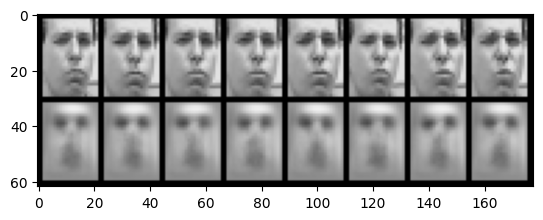

In [13]:
# 1st epoch
image_0 = Image.open("output0.png")
plt.imshow(image_0)

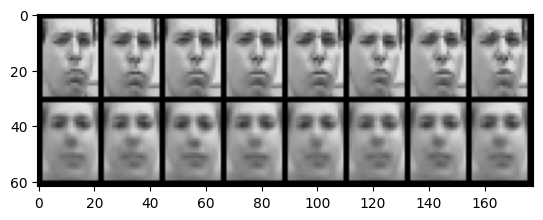

In [14]:
# 5th epoch
image_4 = Image.open("output4.png")
plt.imshow(image_4)

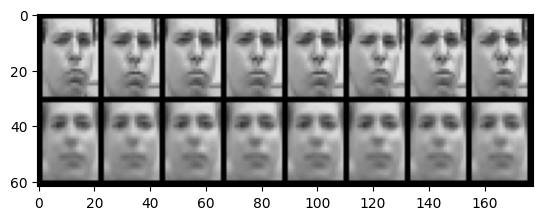

In [15]:
# 20th epoch
image_19 = Image.open("output19.png")
plt.imshow(image_19)